*update 18 Jan 2025, Julian Mak (whatever with copyright, do what you want with this)

### As part of material for OCES 3301 "Data Analysis in Ocean Sciences" delivered at HKUST

For the latest version of the material, go to the public facing [GitHub](https://github.com/julianmak/academic-notes/tree/master/OCES3301_data_analysis_ocean) page.

In [1]:
# load some deafult packages
import matplotlib.pyplot as plt
import numpy as np
import urllib

---------------------------

# 03: linear regression

**Regression** you can (and should?) think of it as data fitting, and getting relationships between different data variables through some statistical means. So if you think about it, **machine learning** or **artificial intelligence** is trying to do something similar with data, so in a way machine learning is really just regression (using more sophisticater algorithms), or standard tools we are going to touch on here (**linear regression** and **multilinear regression**) are really like machine learning 101.

In the process of doing **linear regression** in this session, we will come across other useful (and important) concepts like **mismatches**, **correlation**, **trends**, **goodness-of-fit** and **statistical modelling**.

# NOTE (personal opinion + read because of practical consequences)

One point I want to make here and will be repeating throughout the course is that ***corrleation does not imply causation***, and the key thing I feel like I cannot emphasise enough is that ***regression by default only gives you correlation***. There are so many instances where I see people claiming that their statistical regression "proves" that $x$ causes $y$ or whatever, and this annoys the hell out of me, because

1) regression by deafult gives you correlation and not causation

2) it cheapens the definition of "proof"

At most I think one can claim with statistical evidence is ***consistency*** with whatever hypothesis for causality using statistics/data, because by default we will be talking about likelihoods and probability when using statistics/probability/data. "**Certainty**", which is to me implied by the word "proof", is not the same as "**extremely probable**", while probably good enough for practical purposes, is I think the best we can get with statistical analyses.

### TL;DR

Having said my points, failing to understand/remember the above points to me is laziness/sloppiness. Oerclaiming in the data analysis assignments will lead to ***deductions*** from the scientific portion of the marks in the assigments, for the reasoning that the statements are technically inaccurate and/or sloppy.

<img src="https://i.kym-cdn.com/entries/icons/original/000/028/924/cover2.jpg" width="400" alt='original angry cursed cat'>

> ## Key Objective(s)
> 1. Introduce concept of mismatches and regression as a minimisation problem.
> 2. Apply Python tools to do basic linear regression.
> 3. Explore polynomial regression and the issue of over-fitting.
> 4. Pearson correlation coefficients and its link with linear regression.

--------------------------

# a) Mismatches / errors

Before we get to doing linear regression, lets talk a bit about **mismatches** or sometimes **errors** (errors are part and parcel of these things so while it sounds negative, learn to live with it). Given a "truth", this is just the difference of something relative to your truth.

We need this because the standard way of doing linear regression is to find a linear model that minimised the mismatches of the model to data (more on that later).

Below is the ages example from last time, where the mismatches are defined relative to the (sample) mean $\overline{x}$. The left plot shows the actual data and the mean. The data is my truth, and the mean is my **model** (I could do that, it doesn't necessarily mean it is a good choice). The right plot is just the left plot where I removed the model from the data, i.e. the mean minus the mean is zero, and the data minus the mean is my **signed mismatch (relative to the model)**. For this case this is simply a shift in the graph, no big deal.

actual data                         : [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.], average is 5.0
signed difference to average of data: [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


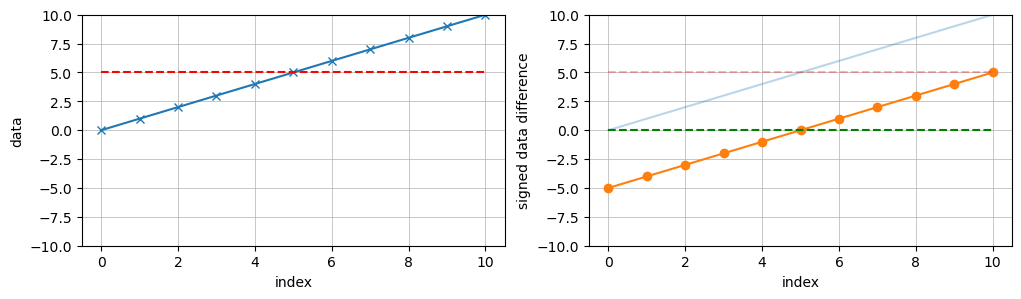

In [2]:
ages = np.linspace(0, 10, 11)
xbar = np.mean(ages)

# one way to measure difference to mean: (signed) difference to mean

ages_err_1 = ages - xbar
print(f"actual data                         : {ages}, average is {xbar}")
print(f"signed difference to average of data: {ages_err_1}")

fig = plt.figure(figsize=(12, 3))
ax = plt.subplot(1, 2, 1)
ax.plot(ages, "-x")
ax.plot([0, 10], [xbar, xbar], "r--")
ax.set_ylim([-10, 10])
ax.set_xlabel(r"index"); ax.set_ylabel(r"data"); ax.grid(lw=0.5, zorder=0);

ax = plt.subplot(1, 2, 2)
ax.plot(ages, alpha = 0.3)
ax.plot(ages_err_1, "-o")
ax.plot([0, 10], [xbar, xbar], "r--", alpha = 0.3)
ax.plot([0, 10], [0, 0], "g--")
ax.set_ylim([-10, 10])
ax.set_xlabel(r"index"); ax.set_ylabel(r"signed data difference"); ax.grid(lw=0.5, zorder=0);

So the point I want to make here is that the choice above is not the only choice, and there are lots of choices you can make. For example, I could choose the **absolute value difference** (related to what is called the **$\ell_1$ norm**), which for this case would be

\begin{equation*}
    \mathrm{err}_1 = |x_i - \overline{x}|,
\end{equation*}

or the **squared difference** (related to what is called the **$\ell_2 norm$**)

\begin{equation*}
    \mathrm{err}_2 = (x_i - \overline{x})^2,
\end{equation*}

and both of these are legitimate measures of mismatch to the mean. The code below shows what these look like.

err_1 to average of data: [5. 4. 3. 2. 1. 0. 1. 2. 3. 4. 5.]
err_2 to average of data: [25. 16.  9.  4.  1.  0.  1.  4.  9. 16. 25.]


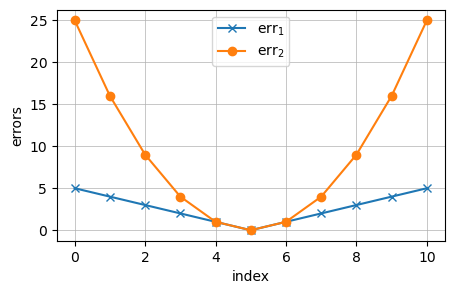

In [3]:
err_1 = np.abs(ages - xbar)  # work out the absolute error, > 0
err_2 = (ages - xbar) ** 2   # square everything > 0

print(f"err_1 to average of data: {err_1}")
print(f"err_2 to average of data: {err_2}")

fig = plt.figure(figsize=(5, 3))
ax = plt.axes()
ax.plot(err_1, "-x", label = r"$\mathrm{err}_1$")
ax.plot(err_2, "-o", label = r"$\mathrm{err}_2$")
ax.set_xlabel(r"index"); ax.set_ylabel(r"errors"); ax.grid(lw=0.5, zorder=0); ax.legend();

The bird-of-prey-eyed among you (like those cursed owls below) may notice that the squared error $\mathrm{err}_2$ is closely related to the variance and standard deviation defined in the previous notebook.

<img src="https://i.imgur.com/2bV06rh.png" width="400" alt='cursed owls'>

> <span style="color:red">**Q.**</span> Make sure you convince yourself how so, because this observation is somewhat important for the next bit.

------------------------

# b) Linear regression

If you are ever going to do regression the first thing you should try is **linear regression**.

Actually, you should probably try plotting the data out first. The next thing you could try is linear regression. Linear regression is when you try and fit a straight line to fit two variables. Given some input $x$ and output $y$, and some input/output *data* $x_i$ and $y_i$, the game here is to find some choice of constants $a$ and $b$ such that the linear model $f(x)$

\begin{equation*}
    y = f(x) = a x + b
\end{equation*}

is a *best fit* to the data $x_i$ and $y_i$ (whatever *best fit* means, but it will be related to our discussion of the mismatch above).

All this sounds a bit formal, so lets go through a simple example, where we actually know the answer, and reverse engineer it a bit to illustrate a few things. Suppose I concoct some artificial data where the TRUTH is actually

\begin{equation*}
    y = x,
\end{equation*}

i.e., $f$ such that $a=1$ and $b=1$. I can cook up some $x_i$ (through `np.linspace` below over some range), and thus I know the exact $y_i$ that should correspond to the input. However, to make it a bit more interesting, when I generate my artificial data $y_i$ through $x_i$, I am going to randomly kick the $y_i$ values around (here with `np.random.rand(n)`, but see note below). For completeness I am also going to plot the squared error relative to the TRUTH (i.e. $(y_i - f(x_i))^2$).

> NOTE: `np.random.rand(n)` is a random number generator (otherwise RNG, or [RNGesus](https://knowyourmeme.com/memes/rngesus)) that by default generates $n$ lots of numbers between and including the interval 0 and 1, with uniform probability (i.e. the associated random variable $R$ follows the uniform distribution on $[0, 1]$, or $R \sim \mathcal{U}[0, 1]$). If I shift all my outputs down by $0.5$ and then multiply it by 2, I get $R \sim \mathcal{U}[-1, 1]$ (although I actually multiply it by more in the code below).
>
> A **seed** for RNGesus specifies the starting location for the RNGesus sequence, done here through `np.random.seed(SEED)`. Any subsequent random numbers returned by RNGesus with a specified seed is always going to give you the same sequence of random numbers (because Random Number Generators are not actually random, but that's a digression...)
>
> NOTE: The sum of the squares of the error is actually the $\ell_2$ error squared, so I've denoted it as such.

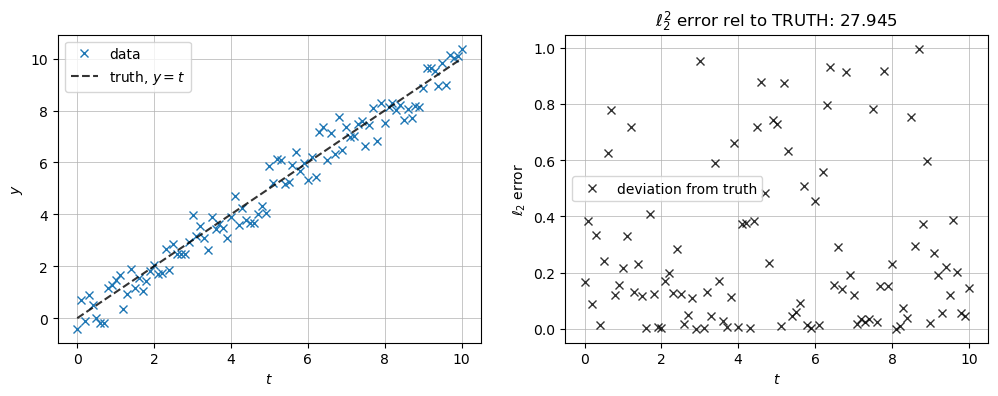

In [4]:
seed = np.random.seed(69)

# just going to draw the line y = t, but randomly add some numbers to the noise because why not
n = 101
t = np.linspace(0, 10, n)
truth = np.linspace(0, 10, n)
data  = np.linspace(0, 10, n)

noise = 2.0 * (np.random.rand(n) - 0.5) # Q. what is the range the random numbers returns should lie in?

data += noise

fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 2, 1)
ax.plot(t, data, "x", label = f"data")
ax.plot(t, truth, "k--", alpha = 0.8, label = f"truth, $y = t$")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
ax.grid(lw=0.5, zorder=0);
ax.legend()

ax = plt.subplot(1, 2, 2)
err_2 = (data - truth) ** 2
ax.plot(t, err_2, "kx", alpha = 0.8, label = f"deviation from truth")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\ell_2$ error")
ax.grid(lw=0.5, zorder=0);
ax.legend()
ax.set_title(f"$\ell_2^2$ error rel to TRUTH: {np.sum(err_2):.3f}");

So the point here is that while in this case there is a truth, in general when we are just dealing with data we only get the blue crosses and not the black line. So given just the blue crosses, how might we try and get a handle on the TRUTH? The main problem here is that there are many (in fact infinitely many) ways to draw a straight line through the data in principle, so given the many choices, how do we judge whether one is better than the other anyway?

So the short answer here is that you fix your definition of mismatch, and sometimes that gives you a unambiguous definition of what is best (i.e. there is a unique minimiser). The standard way of doing this in linear regression is to find $a$ and $b$ such that you minimise the $\ell^2$ mismatch (or the sum of the **root mean squared** mismatch between model and data, denoted $\mathrm{err}_2$ so far), and turns out with this choice of mismatch, there is a *unique* choice of $a$ and $b$ that minimises the mismatch, i.e. there is a **line of best fit** that is *variance minimising*. It turns out there is also an analytical closed form for $a$ and $b$ given input/output data ($x_i$, $y_i$), which is left as an exercise.

So now you know what the line-of-best-fit actually means when you click the button in Excel say. To generate the line of best fit in Python, there are multiple ways of doing this. I am going to do the dirty and verbose way first with `np.polyfit`, which finds the polynomial of degree $n$ given by

\begin{equation*}
    y = p_0 x^n + p_1 x^(n-1) + \ldots + p_n = \sum_{i=0}^n p_i x^{n-i}
\end{equation*}

that is variance minimising (or a **least squares fit**). So doing degree one polyfit gives me the line of best fit, which is done below.

sum of $\ell_2^2$ error rel to TRUTH: 27.945
sum of $\ell_2^2$ error rel to LOBF : 27.252


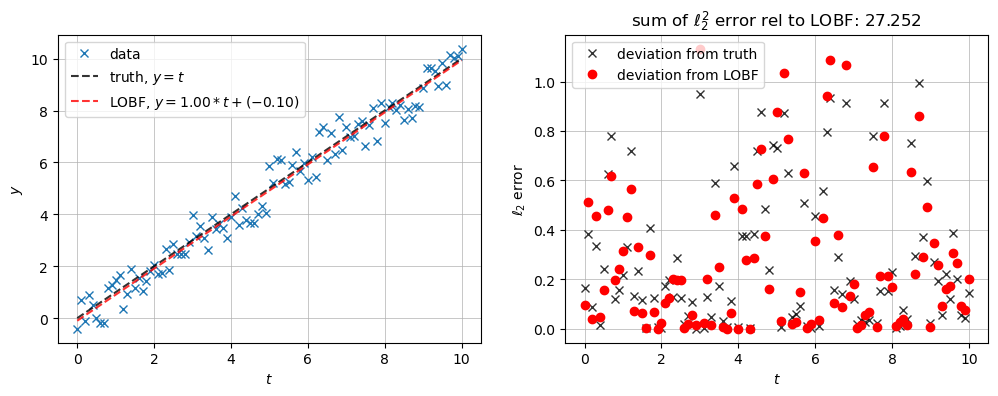

In [5]:
p = np.polyfit(t, data, 1)
line_of_best_fit = p[0] * t + p[1]

fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 2, 1)
ax.plot(t, data, "x", label = f"data")
ax.plot(t, truth, "k--", alpha = 0.8, label = f"truth, $y = t$")
ax.plot(t, line_of_best_fit, "r--", alpha = 0.8, label = f"LOBF, $y = {{{p[0]:.2f}}} * t + ({{{p[1]:.2f}}})$")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
ax.grid(lw=0.5, zorder=0);
ax.legend()

ax = plt.subplot(1, 2, 2)
err_2_truth = (data - truth) ** 2
err_2_lobf  = (data - line_of_best_fit) ** 2
ax.plot(t, err_2_truth, "kx", alpha = 0.8, label = f"deviation from truth")
ax.plot(t, err_2_lobf, "ro", label = f"deviation from LOBF")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\ell_2$ error")
ax.grid(lw=0.5, zorder=0);
ax.legend()
ax.set_title(f"sum of $\ell_2^2$ error rel to LOBF: {np.sum(err_2_lobf):.3f}");

print(f"sum of $\ell_2^2$ error rel to TRUTH: {np.sum(err_2_truth):.3f}")
print(f"sum of $\ell_2^2$ error rel to LOBF : {np.sum(err_2_lobf):.3f}")

The fact that the line of best fit has coefficients `p[0]` and `p[1]` close to the expected answers ($a=1$ and $b=0$) is promising. The agreement is not exact, but of course we don't expect it to be exact, because we got the line of best fit purely from the data (blue crosses). We happen to know what the real answer should be here, but that is coincidental and by construction, and in practice we have no access to it.

> <span style="color:red">**Q.**</span> Why is the regression process above variance minimising?

> <span style="color:red">**Q.**</span> Try messing around with the magnitude of noise (here given by `2.0`) and see if increasing/decreasing it will affect the line of best first results.

> <span style="color:red">**Q.**</span> Add a manual linear model $ax + b$, where you choose either $a=$ `p[0]` or $b=$ `p[1]`, and see what modifying the other coefficient does to the linear line (just skip this if you can argue this mathematically).

> <span style="color:red">**Q.**</span> Suppose you do something like the previous question. Compute the associated $\ell^2$ errors for varying one of the parameters, and see if you can make the errors go below the one of the line of best fit? (You know the answer here, but try and do a numerical investigation of this.)

> <span style="color:red">**Q.**</span> (harder) Do the previous question but systematically, ideally showing plots of how the $\ell^2$ varies with choice of coefficient. 

> <span style="color:red">**Q.**</span> (harder) For the more keen amongst you, extended version of the previous question. Compute $\ell^2$ as a function of both $a$ and $b$, and display the results, ideally demonstrating clearly where in the ($a,b$) parameter space the line of best fit lies, to numerically demonstrate the line of best fit computed above really is *the* $\ell^2$ minimising model.

> <span style="color:red">**Q.**</span> (mathsy) Look up and/or derive the closed form formula for $a$ and $b$ that is $\ell^2$ minimising given data of input/output. Code it up and test it against the line of best fit you obtained from `np.polyfit`.

-----------------

# c) Beyond linear regression, and things that can go wrong

So with access to `np.polyfit`, we don't have to stay with degree 1 polynomials, and in principle we can go as high a degree as we like. There are several things to note:

1) just becasue you can doesn't mean you should; see examples below

2) sometimes you actually can't; `np.polyfit` for example will complain if you try and fit a large degree polynomial when you don't have enough data (because there is not enough data to constrain the coefficients $p_i$ to return a unique solution)

3) and sometimes if you do it you could just end up getting garbage (this is to do with **ill-conditioning** when high degree polynomials are involved, since higher degrees polynomials are expected to be extremely sensitive to changes)

> <span style="color:red">**Q.**</span> convince yourself of the last point (try it with a numerical example)

## higher degree fitting

Below is an example where you fit a quadratic (degree 2 polynomial) to data. The data is linear, so this is formally an illegal move (as in you shouldn't have done it really), but a case where you get lucky and the returned solution isn't completely crazy.

sum of $\ell_2^2$ error rel to TRUTH: 27.945
sum of $\ell_2^2$ error rel to LOBF quad: 27.245
sum of $\ell_2^2$ error rel to LOBF lin : 27.252


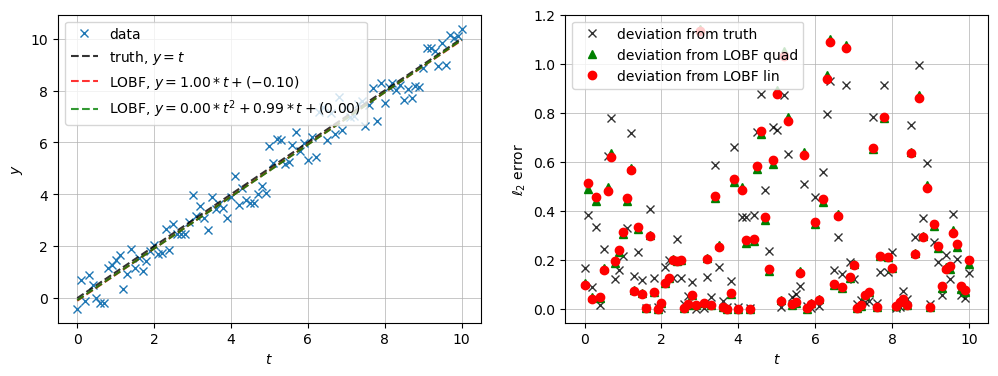

In [6]:
seed = np.random.seed(69)

# just going to draw the line y = t, but randomly add some numbers to the noise because why not
n = 101
t = np.linspace(0, 10, n)
truth = np.linspace(0, 10, n)
data  = np.linspace(0, 10, n)

noise = 2.0 * (np.random.rand(n) - 0.5) # Q. what is the range the random numbers returns should lie in?
data += noise

p1 = np.polyfit(t, data, 1)
line_of_best_fit_lin = p1[0] * t + p1[1]
p2 = np.polyfit(t, data, 2)
line_of_best_fit_quad = p2[0] * t**2 + p2[1] * t + p2[2]

fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 2, 1)
ax.plot(t, data, "x", label = f"data")
ax.plot(t, truth, "k--", alpha = 0.8, label = f"truth, $y = t$")
ax.plot(t, line_of_best_fit_lin , "r--", alpha = 0.8, 
            label = f"LOBF, $y = {{{p1[0]:.2f}}} * t + ({{{p1[1]:.2f}}})$")
ax.plot(t, line_of_best_fit_quad, "g--", alpha = 0.8, 
            label = f"LOBF, $y = {{{p2[0]:.2f}}} * t^2 + {{{p2[1]:.2f}}} * t + ({{{p2[0]:.2f}}})$")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
ax.grid(lw=0.5, zorder=0);
ax.legend()

ax = plt.subplot(1, 2, 2)
err_2_truth = (data - truth) ** 2
err_2_lobf_quad = (data - line_of_best_fit_quad) ** 2
err_2_lobf_lin  = (data - line_of_best_fit_lin) ** 2
ax.plot(t, err_2_truth, "kx", alpha = 0.8, label = f"deviation from truth")
ax.plot(t, err_2_lobf_quad, "g^", label = f"deviation from LOBF quad")
ax.plot(t, err_2_lobf_lin , "ro", label = f"deviation from LOBF lin")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\ell_2$ error")
ax.grid(lw=0.5, zorder=0);
ax.legend()

print(f"sum of $\ell_2^2$ error rel to TRUTH: {np.sum(err_2_truth):.3f}")
print(f"sum of $\ell_2^2$ error rel to LOBF quad: {np.sum(err_2_lobf_quad):.3f}")
print(f"sum of $\ell_2^2$ error rel to LOBF lin : {np.sum(err_2_lobf_lin):.3f}")

I could take it up even high degree (and for cleaniness I am going to use the `np.polyval` command, because it's going to be too long to type out by hand). The code doesn't break as such but it does kick up a warning about fitting being ill-conditioned. Yes the resulting $\ell^2$ error is even lower, but that by itself does not necessarily indicate the model is "good", because 

1) this is done at the expense of a vastly more complicated model

2) the resulting model is extremely sensitive with no robustness when we try and extrapolate; see next point

> NOTE: The first point we can somewhat quantify by rewarding lower misfits, but penalising the complexity; see *04_multilinear_regression*

/tmp/ipykernel_2774977/2960796649.py:1: RankWarning: Polyfit may be poorly conditioned
  p_high = np.polyfit(t, data, 20)


sum of $\ell_2^2$ error rel to TRUTH: 27.945
sum of $\ell_2^2$ error rel to LOBF lin : 27.252
sum of $\ell_2^2$ error rel to LOBF quad: 21.109


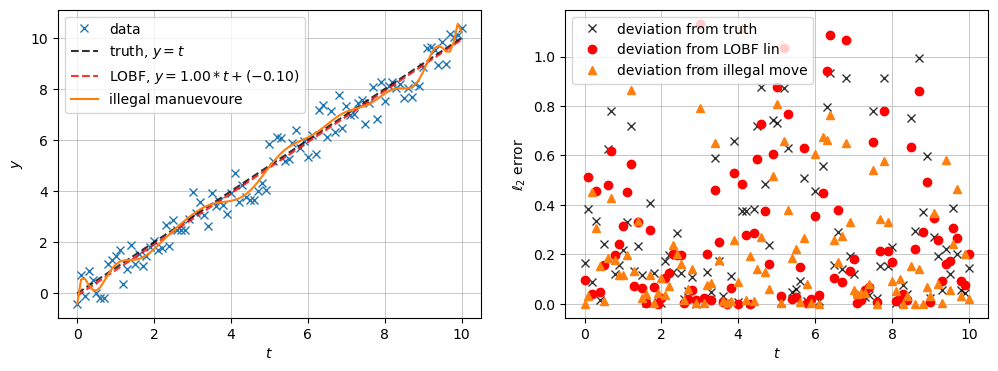

In [7]:
p_high = np.polyfit(t, data, 20)
line_high_deg = np.polyval(p_high, t)

fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 2, 1)
ax.plot(t, data, "x", label = f"data")
ax.plot(t, truth, "k--", alpha = 0.8, label = f"truth, $y = t$")
ax.plot(t, line_of_best_fit_lin , "r--", alpha = 0.8, 
            label = f"LOBF, $y = {{{p1[0]:.2f}}} * t + ({{{p1[1]:.2f}}})$")
ax.plot(t, line_high_deg, "C1-", label="illegal manuevoure")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
ax.grid(lw=0.5, zorder=0);
ax.legend()

ax = plt.subplot(1, 2, 2)
err_2_truth = (data - truth) ** 2
err_2_lobf_lin  = (data - line_of_best_fit_lin) ** 2
err_2_illegal  = (data - line_high_deg) ** 2
ax.plot(t, err_2_truth, "kx", alpha = 0.8, label = f"deviation from truth")
ax.plot(t, err_2_lobf_lin , "ro", label = f"deviation from LOBF lin")
ax.plot(t, err_2_illegal, "C1^", label = f"deviation from illegal move")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\ell_2$ error")
ax.grid(lw=0.5, zorder=0);
ax.legend()

print(f"sum of $\ell_2^2$ error rel to TRUTH: {np.sum(err_2_truth):.3f}")
print(f"sum of $\ell_2^2$ error rel to LOBF lin : {np.sum(err_2_lobf_lin):.3f}")
print(f"sum of $\ell_2^2$ error rel to LOBF quad: {np.sum(err_2_illegal):.3f}")

## Interpolation + extrapolation (primer to `08_time_series`)

Once you have a model you can in principle use it over any range of data. **Interpolating** referes to when the regressed model is used within the range of data that was used to generate the regressed model in the first place. This one is usually ok to do, not really going to do this one.

**Extrapolating** is when you used the model outside of the range of data used to generate the regressed model. This can be problematic, and use this with caution. 

Below is an example that demonstrates how bad it can be. We are going to be using the same data and regressed models in the cell above, but extend the range of input values a bit. The left one we leave out the line for the high degree fit, while the other one we leave in both.

/tmp/ipykernel_2774977/289664285.py:5: RankWarning: Polyfit may be poorly conditioned
  p_high = np.polyfit(t, data, 20)


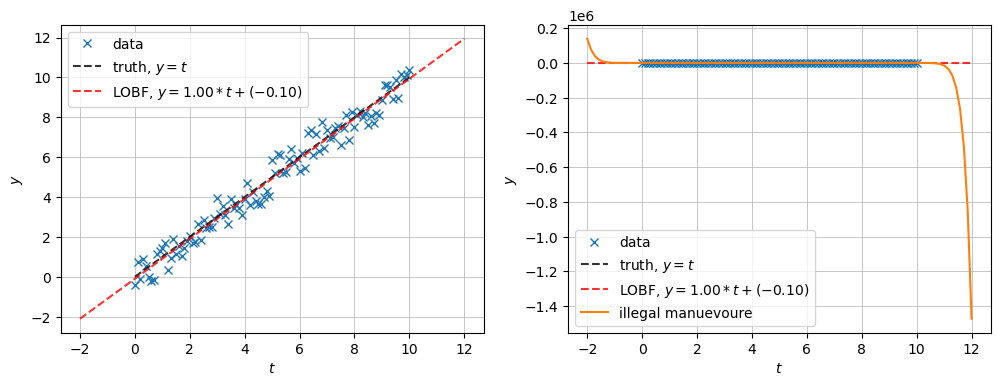

In [8]:
t_extended = np.linspace(-2, 12, n)

p1 = np.polyfit(t, data, 1)
line_of_best_fit_lin = np.polyval(p1, t_extended)
p_high = np.polyfit(t, data, 20)
line_high_deg = np.polyval(p_high, t_extended)

fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 2, 1)
ax.plot(t, data, "x", label = f"data")
ax.plot(t, truth, "k--", alpha = 0.8, label = f"truth, $y = t$")
ax.plot(t_extended, line_of_best_fit_lin , "r--", alpha = 0.8, 
            label = f"LOBF, $y = {{{p1[0]:.2f}}} * t + ({{{p1[1]:.2f}}})$")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
ax.grid(lw=0.5, zorder=0);
ax.legend()

ax = plt.subplot(1, 2, 2)
ax.plot(t, data, "x", label = f"data")
ax.plot(t, truth, "k--", alpha = 0.8, label = f"truth, $y = t$")
ax.plot(t_extended, line_of_best_fit_lin , "r--", alpha = 0.8, 
            label = f"LOBF, $y = {{{p1[0]:.2f}}} * t + ({{{p1[1]:.2f}}})$")
ax.plot(t_extended, line_high_deg, "C1-", label="illegal manuevoure")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
ax.grid(lw=0.5, zorder=0);
ax.legend()

This is an extreme example but you see the issue here I hope. While the linear regression model will basically do sensible things (because there aren't that many degrees of freedom in the coefficients for it to go nuts), that is not the case with the high degree polynomial fitting, taking insane values even just a little beyond the data range. 

This is a one of the property of models that are **over-fitted**. Below is a converse case where the linear regression model is **under-fitted**, and it is simply unable in representing the data within the region with data (and certainly not outside of it).

> NOTE: This is a case where a simple plotting in the first place would have told you you shouldn't never have tried to use linear regression in the first place.

> NOTE: This is also a case where you can't just be using linear regression all the time, because not everything is linear.

sum of $\ell_2^2$ error rel to TRUTH: 698.630
sum of $\ell_2^2$ error rel to LOBF quad: 681.132
sum of $\ell_2^2$ error rel to LOBF lin : 94311.104


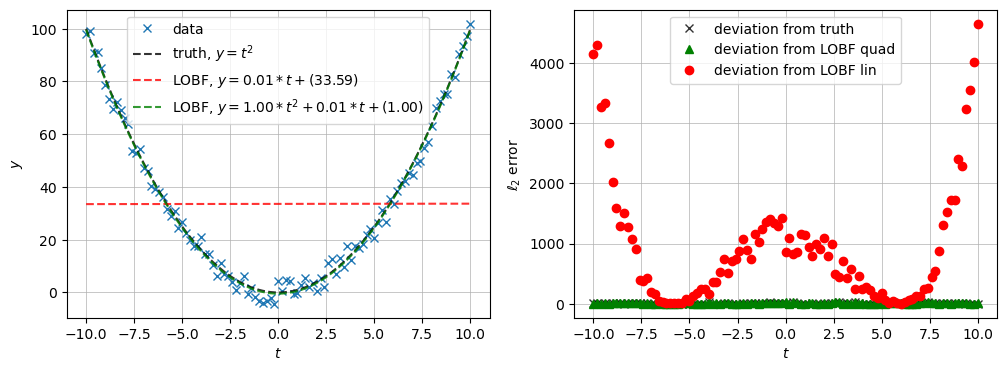

In [9]:
seed = np.random.seed(69)

n = 101
t = np.linspace(-10, 10, n)
truth = np.linspace(-10, 10, n) ** 2
data  = np.linspace(-10, 10, n) ** 2

# make the noise bigger
noise = 10.0 * (np.random.rand(n) - 0.5)
data += noise

p2 = np.polyfit(t, data, 2)
line_of_best_fit_quad = p2[0] * t**2 + p2[1] * t + p2[2]

p1 = np.polyfit(t, data, 1)
line_of_best_fit_lin  = p1[0] * t + p1[1]

fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 2, 1)
ax.plot(t, data, "x", label = f"data")
ax.plot(t, truth, "k--", alpha = 0.8, label = f"truth, $y = t^2$")
ax.plot(t, line_of_best_fit_lin , "r--", alpha = 0.8, 
            label = f"LOBF, $y = {{{p1[0]:.2f}}} * t + ({{{p1[1]:.2f}}})$")
ax.plot(t, line_of_best_fit_quad, "g--", alpha = 0.8, 
            label = f"LOBF, $y = {{{p2[0]:.2f}}} * t^2 + {{{p2[1]:.2f}}} * t + ({{{p2[0]:.2f}}})$")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
ax.grid(lw=0.5, zorder=0);
ax.legend()

ax = plt.subplot(1, 2, 2)
l2_err_truth = (data - truth) ** 2
l2_err_lobf_quad = (data - line_of_best_fit_quad) ** 2
l2_err_lobf_lin  = (data - line_of_best_fit_lin) ** 2
ax.plot(t, l2_err_truth, "kx", alpha = 0.8, label = f"deviation from truth")
ax.plot(t, l2_err_lobf_quad, "g^", label = f"deviation from LOBF quad")
ax.plot(t, l2_err_lobf_lin , "ro", label = f"deviation from LOBF lin")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\ell_2$ error")
ax.grid(lw=0.5, zorder=0);
ax.legend()

print(f"sum of $\ell_2^2$ error rel to TRUTH: {np.sum(l2_err_truth):.3f}")
print(f"sum of $\ell_2^2$ error rel to LOBF quad: {np.sum(l2_err_lobf_quad):.3f}")
print(f"sum of $\ell_2^2$ error rel to LOBF lin : {np.sum(l2_err_lobf_lin):.3f}")

If you have a bendy boi like the cursed dragon Haku below then you might want to be a bit careful with linear regression. Sometime it can still useful, but then thing is think about whether you can defend an action, and don't do things blindly.

<img src="https://i.imgur.com/rRDngzC.jpg" width="400" alt='cursed owls'>

## A slightly more pathological case

In the example below I just randomly generate numbers, so any fitting should fail. I can still do the fitting, but any outcome by default is artificial.

So, again, just because you can do it does not mean you should, or the end result is "good". One always have to judge these things by various metrics (in this case the mismatches would tell you the regressed model is not great).

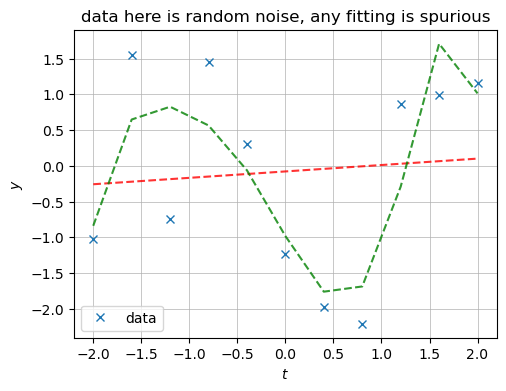

In [10]:
seed = np.random.seed(69)

n = 11
t = np.linspace(-2, 2, n)
data  = 5.0 * (np.random.rand(n) - 0.5)

p6 = np.polyfit(t, data, 6)
line_high_deg = np.polyval(p6, t)

p1 = np.polyfit(t, data, 1)
line_of_best_fit  = p1[0] * t + p1[1]

fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 2, 1)
ax.plot(t, data, "x", label = f"data")
ax.plot(t, line_of_best_fit , "r--", alpha = 0.8)
ax.plot(t, line_high_deg, "g--", alpha = 0.8)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
ax.set_title("data here is random noise, any fitting is spurious")
ax.grid(lw=0.5, zorder=0);
ax.legend()

## existing packages

Given that linear regression is so prevalent, it is in `scipy.stats`. See below for an example of the syntax; here `s` is the slope and `c` is the constant (so `p[0]` and `p[1]` when using `np.polyfit` with degree 1).

> NOTE: the underscore `_` means do not save the relevant output to any variable. I need this in this case because `stats.linregress` by default gives me 5 outputs, but I only really want the 1st, 2nd and 5th (the other two are `rvalue` and `pvalue`; check this with `stats.linregress?`)

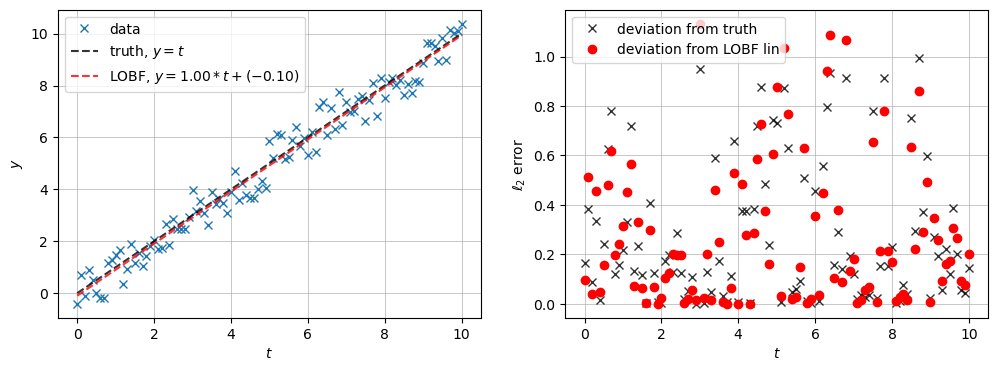

In [11]:
from scipy import stats

# define the data (same as linear example above)
seed = np.random.seed(69)
n = 101
t = np.linspace(0, 10, n)
truth = np.linspace(0, 10, n)
data  = np.linspace(0, 10, n)

noise = 2.0 * (np.random.rand(n) - 0.5)
data += noise

# slope, intercept, r-value, p-value from t_test, std = stats.linregress(input, output)
s, c, _, _, std_err = stats.linregress(t, data)

line_of_best_fit_lin = s * t + c

fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 2, 1)
ax.plot(t, data, "x", label = f"data")
ax.plot(t, truth, "k--", alpha = 0.8, label = f"truth, $y = t$")
ax.plot(t, line_of_best_fit_lin , "r--", alpha = 0.8, 
            label = f"LOBF, $y = {{{s:.2f}}} * t + ({{{c:.2f}}})$")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
ax.grid(lw=0.5, zorder=0);
ax.legend()

ax = plt.subplot(1, 2, 2)
l2_err_truth = (data - truth) ** 2
l2_err_lobf_lin  = (data - line_of_best_fit_lin) ** 2
ax.plot(t, l2_err_truth, "kx", alpha = 0.8, label = f"deviation from truth")
ax.plot(t, l2_err_lobf_lin , "ro", label = f"deviation from LOBF lin")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\ell_2$ error")
ax.grid(lw=0.5, zorder=0);
ax.legend()

There is also one in `scikit.learn` too, but you can look at this in your own time if you like. We may touch on `scikit.learn` in the extra material in this course if there is enough appetite for that.

---------------------------

# d) Correlation coefficient and trends

## (Pearson) corrrelation coefficient

So `scipy.stats.linregress` also additionally gives you the **(Pearson) correlation coefficient** or **$r$-value**; see [here](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient). The page gives you a formula to actually compute these by hand, which requires computation of **covariance**, but we are going to skip (but see exercise below).

The thing you mostly need to know where is that the $r$-value lies between -1 and 1. Usually,

* 1 and -1 means the data is perfectly correlated or anti-correlated
* 0 is no obvious correlation between variables
* anything about 0.9 magnitude is probably reasonably good correlation, and values below ranges from either suggestive or just noise

The thing to note here is that the correlations represented by the $r$-value is ***only from a linear regression point of view***. There can be things that are obviously "correlated", but have a $r$-value of zero (example below, but also see *07_time_series* for another one).

The below two examples basically computes the $r$-values with `stats.linregress` for two of the examples above, one with the linear data, and the other with the quadratic data. Have a think about the answer you should expect before you run the code.

In [12]:
# define the data (same as linear example above)
seed = np.random.seed(69)
n = 101
t = np.linspace(0, 10, n)
truth = np.linspace(0, 10, n)
data  = np.linspace(0, 10, n)

noise = 2.0 * (np.random.rand(n) - 0.5)
data += noise

_, _, r, _, std_err = stats.linregress(t, data)

print(f"(Pearson) correlation coefficient is {r:.3f}")

(Pearson) correlation coefficient is 0.985


In [13]:
seed = np.random.seed(69)

n = 101
t = np.linspace(-10, 10, n)
truth = np.linspace(-10, 10, n) ** 2
data  = np.linspace(-10, 10, n) ** 2

# make the noise bigger
noise = 10.0 * (np.random.rand(n) - 0.5)
data += noise
_, _, r, _, std_err = stats.linregress(t, data)

print(f"(Pearson) correlation coefficient is {r:.3f}")

(Pearson) correlation coefficient is 0.002


> <span style="color:red">**Q.**</span> (theoretical) While the above are examples of the Pearson correlation coefficient, there is also this one (that you may have heard of) called the **[Spearman's rank correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)** or the Spearman **$\rho$-value**. See if you can explain how the two differ.

> <span style="color:red">**Q.**</span> Look up the syntax for calculating Spearman's $\rho$-value for some examples above.

> <span style="color:red">**Q.**</span> Compute the Pearson correlation by hand (by which I mean in Python without using the 3rd output of `stats.linregress`) with one of the examples above (or cook your own up, it doesn't really matter). The thing you probably need here is `np.cov`, which estimates the **correlation matrix**.

## (Linear) trends

The **(linear) trend** is just another word for the slope of the (linear) line of best fit, or the $a$ coefficient. For $y = ax + b$, The trend or the $a$ coefficient encodes information about how much the output $y$ changes with each unit change in input $x$.

To illustrate this, lets go to some real data. The code below is almost a direct copy of the El Nino 3.4 SST data that we looked at in the last session.

loading data remotely


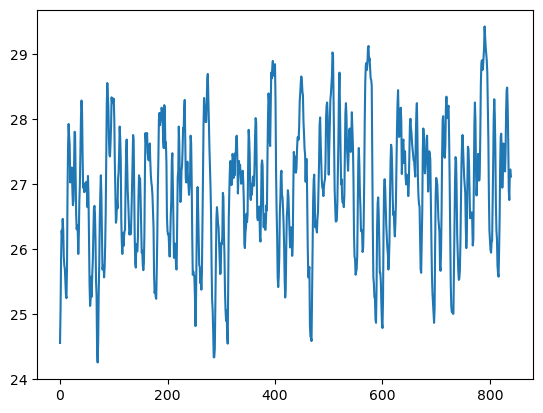

In [14]:
option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    f = open("elnino34_sst.data", "r")
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES3301_data_analysis/refs/heads/main/elnino34_sst.data"
    f = urllib.request.urlopen(path)
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

elnino34_txt = f.readlines()
elnino34_txt = elnino34_txt[3:-4]
for k in range(len(elnino34_txt)):
    if type(elnino34_txt[k]) == str:
        elnino34_txt[k] = elnino34_txt[k].strip("\n")
    elif type(elnino34_txt[k]) == bytes:
        elnino34_txt[k] = elnino34_txt[k].decode("utf-8").strip("\n")
        
# define an empty list, cycle through each line, split, and add in the entries
elnino34_sst = []
for k in range(len(elnino34_txt)):           # this is the new elnino34_txt after stripping out some lines
    dummy = elnino34_txt[k].split()          # split out the entries per line
    for i in range(1, len(dummy)):           # cycle through the dummy list but skip the first entry
        elnino34_sst.append(float(dummy[i])) # turn string into a float, then add to list

elnino34_sst = np.asarray(elnino34_sst)      # turn into array (not strictly necessary)

plt.plot(elnino34_sst)  # quick dirty plot

The SST is an array, and we know in this case there is a time associated with the data. If you did do the example from last time in generating the time array then you could just feed it into the linear regression and compute accordingly. The way I did it is below.

> NOTE: By default `np.linspace(1950, 2020, n)` would have generated points inclusive of the right hand end point, so there is `2020.00` which we are essentially taking to correspond to `Jan 2020`. But the last data point we have is for `Dec 2019`, so there is a slight mismatch of the time array to data (and in fact everything except the first point in the data array would be slightly off if we did the above). If we put in the `endpoint=False` keyword, then by default it generates `n` points that are linearly spaced such that is does not include `2020.00`, which gives the right spacing for the trend. 
>
> The error introduced would not be huge and the conclusion doesn't actually change that much, but the result would technically be wrong.

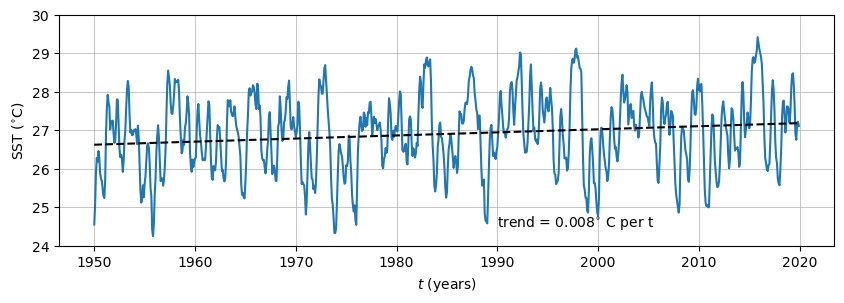

In [15]:
t_vec = np.linspace(1950, 2019+1, len(elnino34_sst), endpoint=False)
s, c, _, _, std_err = stats.linregress(t_vec, elnino34_sst)
lin_trend = s * t_vec + c

fig = plt.figure(figsize=(10, 3))
ax = plt.axes()
ax.plot(t_vec, elnino34_sst, 'C0')
ax.plot(t_vec, lin_trend, 'k--')
ax.text(1990, 24.5, f"trend = ${s:.3f}^{{\circ}}\ \mathrm{{C}}$ per t", color="k")
ax.set_xlabel(r"$t$ (years)")
ax.set_ylabel(r"SST (${}^{\circ}\mathrm{C}$)")
ax.set_ylim(24, 30)
ax.grid(lw=0.5, zorder=0);

> <span style="color:red">**Q.**</span> Fix the units for the trend.

> <span style="color:red">**Q.**</span> Did you expect this the trend? Whats the reasoning behind this?

> <span style="color:red">**Q.**</span> Suppose the colleague of yours that you despise the most, after having done this linear regression analysis, concludes that "time causes temperature to rise". Put them down as brutally as you can while being scientifically correct and without attacking them as a person (having a scientific debate?)

> <span style="color:red">**Q.**</span> What is the total warming implied by the trend from 1950 to 2020?

> <span style="color:red">**Q.**</span> What is the implied average temperature of the El Nino 3.4 region in 2050 by the trend? Use the information you have already to compute this in Python.

> <span style="color:red">**Q.**</span> Calculate the standard deviation from elnino34_sst. The calculated implied average temperature in 2050 would be regarded as a mean, and it is important to acknowledge and provide uncertainties where possible. Supposing the standard deviation stays the same throughout the period, give the projected average temperature in 2050 with the uncertainty of 2 standard deviations.

> <span style="color:red">**Q.**</span> (need to look up syntax) Assuming standard deviation isn't evolving in time, Plot the time-series with the 2 standard deviatons **confidence interval** (you could look forward to *05_statistical_tests* if you want, or just Google what that means; you probably do want to look up the Python syntax for plotting the **uncertainty range** or **error bars** in a time-series)

> <span style="color:red">**Q.**</span> (somewhat open, and situation occurs more often than you think) Suppose the media gets hold of your result and reports that
>
>        "global average 2050 temperature to be [whatever result you found], international policy a faliure"
>
> Critcise this hypothetical media company in as many possible ways on the kind of garbage reporting they are doing (maybe stop at around 10 if you get that far).

One last one before we close for the session. **De-trending** in this case means taking the the (linear) trend off the data. The result you get are sometimes called the **anomalies**. So for example the variance is related to the sum of the squares of the anomalies (up to a factor of sample size). The result of doing this on El Nino 3.4 SST look like the case below.

> NOTE: You can of course take quadratic trends off if you fit a quadratic model, and so on.

> NOTE: We will use the `endpoint=False` command again later in *08_time_series*, as well as de-trending, when dealing with Fourier transforms and spectrum analysis.

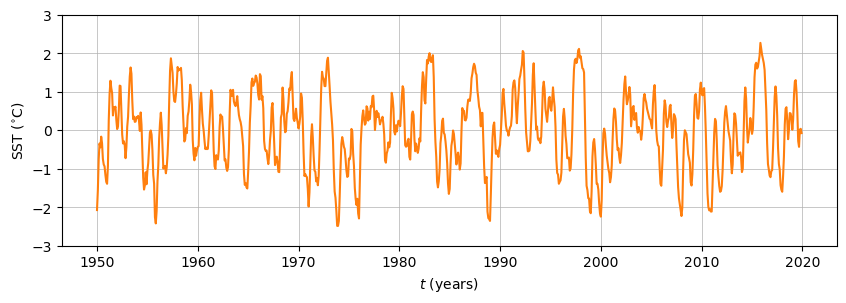

In [16]:
t_vec = np.linspace(1950, 2019+1, len(elnino34_sst), endpoint=False)
s, c, _, _, std_err = stats.linregress(t_vec, elnino34_sst)
lin_trend = s * t_vec + c

fig = plt.figure(figsize=(10, 3))
ax = plt.axes()
ax.plot(t_vec, elnino34_sst - lin_trend, 'C1')
ax.set_xlabel(r"$t$ (years)")
ax.set_ylabel(r"SST (${}^{\circ}\mathrm{C}$)")
ax.set_ylim(-3, 3)
ax.grid(lw=0.5, zorder=0);

> <span style="color:red">**Q.**</span> If you did a linear regression on the de-trended signal, what should you get? Check your answer and actually do the calculation.

-----------------

# More involved exercises with this notebook

## 1) Other El-Nino 3.4 data

There is another dataset called `elnino34_olr.data` (this is **outgoing longwave radiation**; look up Wikipedia or OCES 2003 for what this means if you don't remember), at the same frequency (monthly averaged), but over a time period that is not completely the same as the corresponding SST data. The link is here: https://raw.githubusercontent.com/julianmak/OCES3301_data_analysis/refs/heads/main/elnino34_olr.data

> <span style="color:red">**Q.**</span> Open the file and have a look at the data, and adapt some code (or write your own) to read the data into Python. 
>
> NOTE: `-99.9` again means there is no data, and you may have to think about what to do with that.

> <span style="color:red">**Q.**</span> Do the kind of analysis carried out so far for this set of data, to get a sense of what the data is like. 
>
> NOTE 1: You will need to re-define or define another time-array. I would recommend you do the latter, though in principle both would work as long as you are careful with indexing or know the shorthand to get at the corresponding indices in the time array that is longer.
>
> NOTE 2: You also need to think about what to do with the missing data if you want to do linear regression, because regression might fail otherwise.

> <span style="color:red">**Q.**</span> Compare the SST and OLR data during the overlapping period and do some correlation analysis etc. This requires you pick out the data in the overlapping period accordingly.

> <span style="color:red">**Q.**</span> (A bit of thinking) Are the correlations you see consistent with what you might expect? Why? (OCES 2003 should have covered this a bit.)

> <span style="color:red">**Q.**</span> Detrend the data accordingly and see if the above two questions change in the answer.

## 2) $\ell_1$ minimiser

(Probably quite hard, fairly involved, and possibly open-ended)

We normally stick with $\ell_2$ minimisers because there are some nice properties associated with them, such as being able to proof (and here I really mean proof) that there is a unique $\ell^2$ minimiser given data (partly because the $\ell_2$ norm is differentiable). 

However the choice of $\ell_2$ is not the only choice, and $\ell_1$ minimisers are known to give less weight the outliers less (because it is not squaring the mismatch), but the routines to get obtain these minimisers are not so easy to obtain (partly because $\ell_1$ norm is not differentiable everywhere). See if you can either find some code online that does this, try it on some data (cook this up or use some of the example provided), and investigate how they compare with the standard least squares $\ell_2$ minimisers.

If you are really feeling creative, you can probably write your own. You can probably do this with clever uses of `scipy.optimize.minimize` or `scipy.optimize.linprog` might do it.